In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are errors with LAMMPS
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "GaN_0001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)
logging.getLogger(
    "matplotlib.font_manager"
).disabled = True  # disable matplotlib font manager logging

# Load prepared pristine slab
try:
    with open("data/GaN_0001/GaN_0001_3x3_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "chem_pots": {"Ga": 5},  # eV. arbitrary value
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": run_folder,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 104,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": True,
    "alpha": 0.99,  # slowly anneal
    "canonical": True,
    "num_ads_atoms": 12,
    "adsorbates": ["Ga"],
    "run_folder": run_folder,
}

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [4]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

10:07:10 - mcmc.calculators | INFO: run directory: GaN_0001 is set from parameters
10:07:10 - mcmc.calculators | INFO: relaxation steps: 100 is set from parameters


/home/dux/NeuralForceField/models


{'calc_name': 'LAMMPS',
 'optimizer': 'LAMMPS',
 'chem_pots': {'Ga': 5},
 'relax_atoms': True,
 'relax_steps': 100,
 'run_dir': PosixPath('GaN_0001')}

In [5]:
import os

os.environ

environ{'USER': 'dux',
        'SSH_CLIENT': '10.31.169.98 57197 22',
        'XDG_SESSION_TYPE': 'tty',
        'SHLVL': '2',
        'MOTD_SHOWN': 'pam',
        'HOME': '/home/dux',
        'OLDPWD': '/home/dux',
        'SSL_CERT_FILE': '/usr/lib/ssl/certs/ca-certificates.crt',
        'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1026/bus',
        'LOGNAME': 'dux',
        '_': '/home/dux/miniforge3/envs/vssr-mc/bin/python',
        'XDG_SESSION_CLASS': 'user',
        'VSCODE_CLI_REQUIRE_TOKEN': '61fe5d2b-6e46-4619-bd57-22ab43e398a7',
        'XDG_SESSION_ID': '40473',
        'PATH': '/home/dux/miniforge3/envs/vssr-mc/bin:/home/dux/.vscode-server/cli/servers/Stable-ea1445cc7016315d0f5728f8e8b12a45dc0a7286/server/bin/remote-cli:/home/dux/QUIP/build/linux_x86_64_gfortran:/home/dux/miniforge3/envs/vssr-mc/bin:/home/dux/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin',
        'VSCODE_AGENT_FOLDER': '/home/du

Initialize surface system

In [6]:
surface = SurfaceSystem(
    slab,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "GaN_0001_3x3_all_virtual_ads.cif")

10:07:10 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'GaN_0001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
10:07:11 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 0.   ,  0.   , 14.766]), array([12.865,  7.428, 14.12 ]), array([12.865,  5.571, 14.766]), array([11.257,  4.642, 14.12 ]), array([ 1.608,  2.785, 14.766])]...
10:07:11 - mcmc.system | INFO: Initializing 107 virtual atoms
10:07:11 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10:07:11 - mcmc.system | INFO: Number of pristine atoms is 36
10:07:11 - mcmc.system | INFO: Bulk indices are [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35]
10:07:

Total wall time: 0:00:00


Test calculate pristine surface

In [7]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Energy -144.059 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `GaN(0001)/` folder.

10:07:11 - mcmc.mcmc | INFO: Using run folder GaN_0001
10:07:11 - mcmc.mcmc | INFO: Randomly adsorbing sites
10:07:11 - mcmc.events.criterion | ERROR: No surface energy found in results dict
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None


10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None
10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00


10:07:12 - mcmc.mcmc | INFO: There are 36 atoms in pristine slab
10:07:12 - mcmc.mcmc | INFO: Running with total_sweeps = 10, sweep_size = 104, start_temp = 1.000
10:07:12 - mcmc.mcmc | INFO: Starting with iteration 0
10:07:12 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '0.990', '0.980', '0.970', '0.961', '0.951', '0.941', '0.932', '0.923', '0.914']
10:07:12 - mcmc.mcmc | INFO: In sweep 1 out of 10
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None
10:07:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:12 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:13 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:14 - mcmc.calculators | INFO: None
10:07:14 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None
10:07:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.mcmc | INFO: At iter 104


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.calculators | INFO: None
10:07:16 - mcmc.system | INFO: Optimized structure has surface energy = -174.577
10:07:16 - mcmc.mcmc | INFO: In sweep 2 out of 10
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:17 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:18 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:19 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None
10:07:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.mcmc | INFO: At iter 208
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.system | INFO: Optimized structure has surface energy = -177.414
10:07:21 - mcmc.mcmc | INFO: In sweep 3 out of 10
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:21 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None
10:07:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:23 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:24 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None
10:07:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.mcmc | INFO: At iter 312
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.system | INFO: Optimized structure has surface energy = -176.994
10:07:26 - mcmc.mcmc | INFO: In sweep 4 out of 10
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:26 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:27 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:28 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:29 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.mcmc | INFO: At iter 416
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.system | INFO: Optimized structure has surface energy = -178.785
10:07:30 - mcmc.mcmc | INFO: In sweep 5 out of 10
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:30 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None
10:07:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:32 - mcmc.calculators | INFO: None
10:07:32 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:33 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:34 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.mcmc | INFO: At iter 520
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.system | INFO: Optimized structure has surface energy = -177.173
10:07:35 - mcmc.mcmc | INFO: In sweep 6 out of 10
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:35 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:36 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:37 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:38 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:39 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.mcmc | INFO: At iter 624
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.system | INFO: Optimized structure has surface energy = -178.399
10:07:40 - mcmc.mcmc | INFO: In sweep 7 out of 10
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:40 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None
10:07:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:42 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:43 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.mcmc | INFO: At iter 728


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.system | INFO: Optimized structure has surface energy = -176.466
10:07:44 - mcmc.mcmc | INFO: In sweep 8 out of 10
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:44 - mcmc.calculators | INFO: None
10:07:44 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:45 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None
10:07:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:47 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:48 - mcmc.calculators | INFO: None
10:07:48 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.mcmc | INFO: At iter 832
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.system | INFO: Optimized structure has surface energy = -177.305
10:07:49 - mcmc.mcmc | INFO: In sweep 9 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:49 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:50 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:51 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:52 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.mcmc | INFO: At iter 936
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.system | INFO: Optimized structure has surface energy = -178.319
10:07:53 - mcmc.mcmc | INFO: In sweep 10 out of 10
10:07:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:53 - mcmc.calculators | INFO: None
10:07:53 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None
10:07:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:54 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:55 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:56 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.mcmc | INFO: At iter 1040
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.calculators | INFO: None
10:07:57 - mcmc.system | INFO: Optimized structure has surface energy = -177.075


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 46.306 seconds


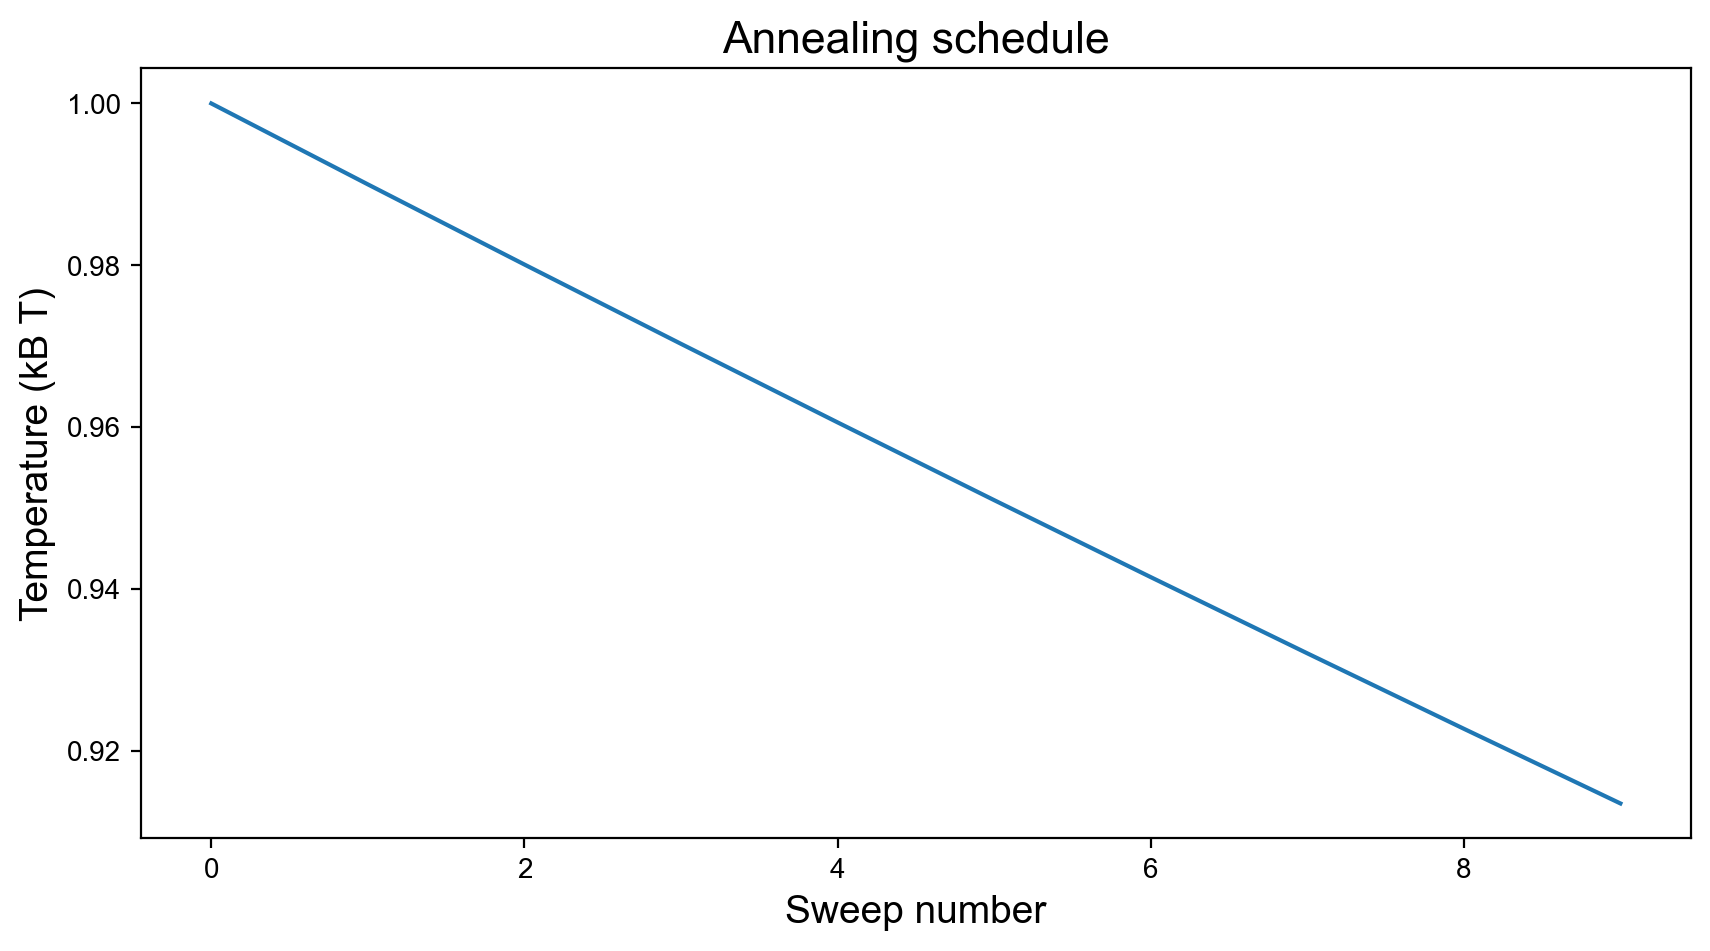

In [8]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Plot results

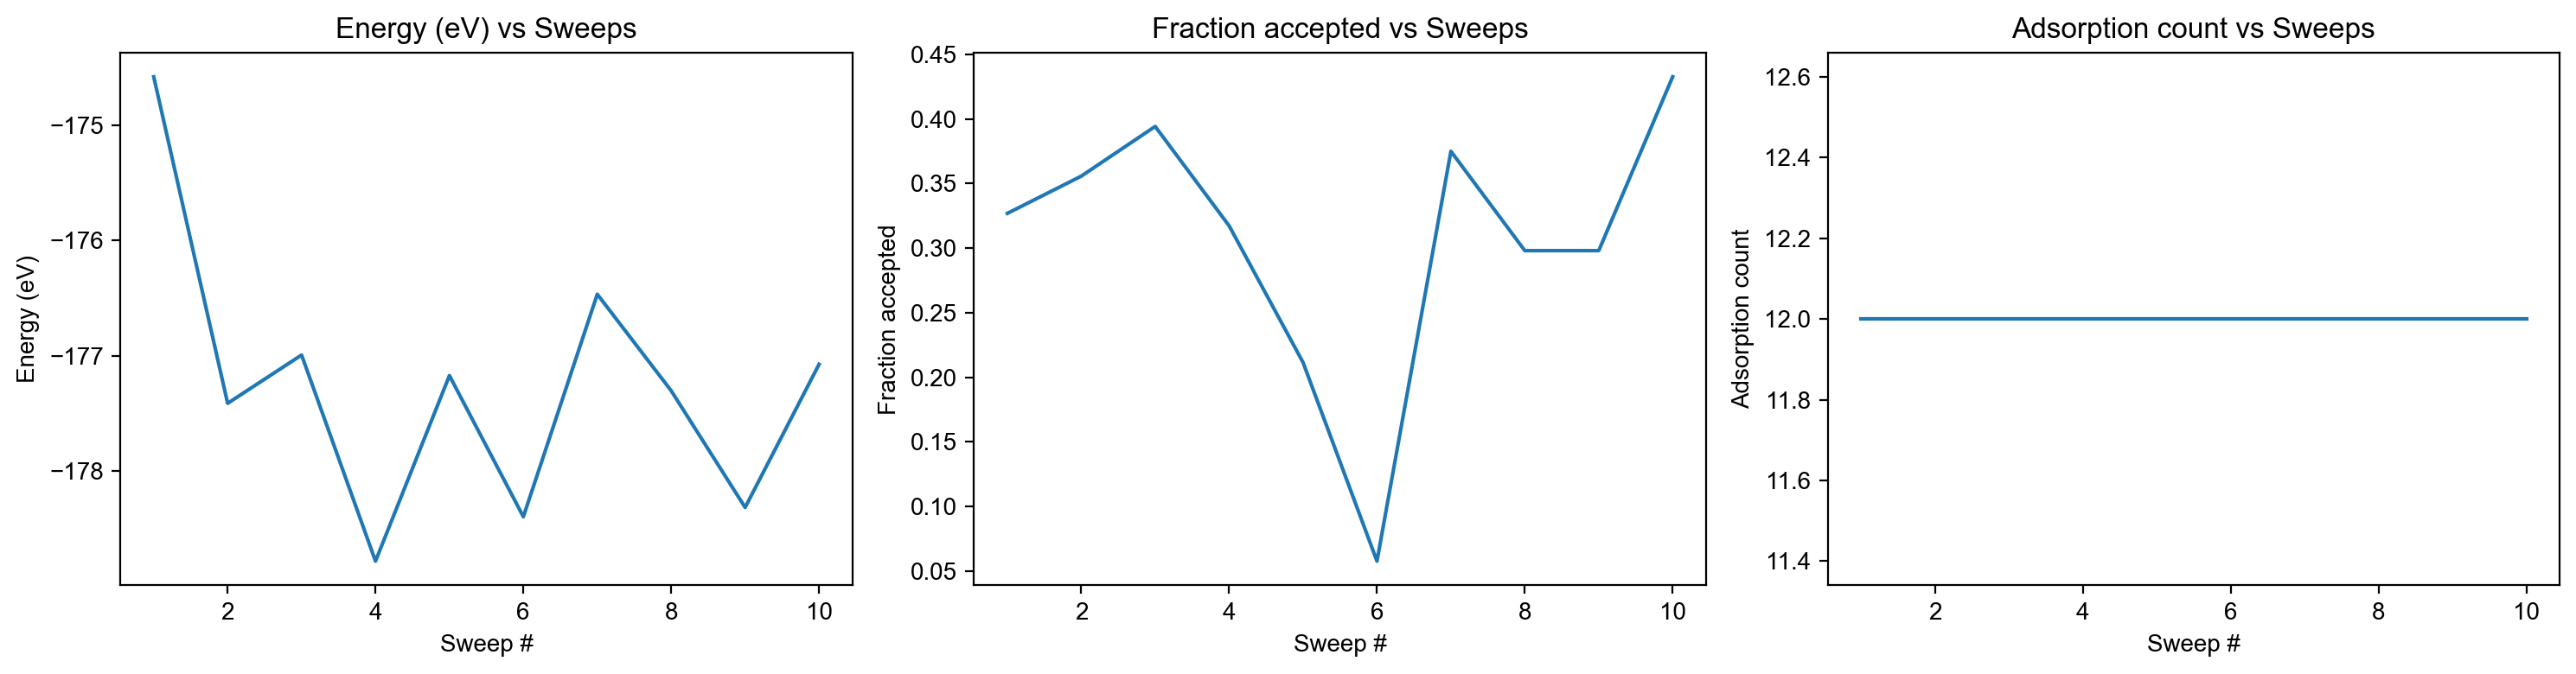

In [9]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)